<a href="https://colab.research.google.com/github/annethecodegirl/Machine-Learning-for-Econometrics-/blob/main/Flexible_models_practical_session.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


The aim of the exercise is to get familiar with the histogram gradient-boosting in scikit-learn. Besides, we will use this model within a cross-validation framework in order to inspect internal parameters found via grid-search.

We will use the California housing dataset.

In [ ]:
from sklearn.datasets import fetch_california_housing

data, target = fetch_california_housing(return_X_y=True, as_frame=True)
target *= 100  # rescale the target in k$

### 📝 TODO: First, create a histogram gradient boosting regressor. You can set the trees number to be large, and configure the model to use early-stopping.

In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor
hist_gbdt = HistGradientBoostingRegressor(
    max_iter=1000, early_stopping=True, random_state=0
)

### 📝 TODO: Use `RandomizedSearchCV` with `n_iter=20` to find the best set of
hyperparameters by tuning the following parameters of the `model`:
- max_depth: [3, 8];
- max_leaf_nodes: [15, 31];
- learning_rate: [0.1, 1].

Notice that in the notebook "Hyperparameter tuning by randomized-search" we
pass distributions to be sampled by the `RandomizedSearchCV`. In this case we
define a fixed grid of hyperparameters to be explored. Using a `GridSearchCV`
instead would explore all the possible combinations on the grid, which can be
costly to compute for large grids, whereas the parameter `n_iter` of the
`RandomizedSearchCV` controls the number of different random combination that
are evaluated. Notice that setting `n_iter` larger than the number of possible
combinations in a grid would lead to repeating
already-explored combinations. Here, this can't happen since the learning rate is sampled from a uniform so the number of possible combinations is infinite.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
# CODE HERE
param_distributions = {"max_depth": [3, 8],
    "max_leaf_nodes": [15, 31],
    "learning_rate": [0.1, 1],}

model_random_search = RandomizedSearchCV(hist_gbdt, param_distributions)

📝 TODO: Secondly, we will run our experiment through cross-validation. In this regard, define a 5-fold cross-validation. Besides, be sure to shuffle the data. Subsequently, use the function sklearn.model_selection.cross_validate to run the cross-validation. You should also set return_estimator=True, so that we can investigate the inner model trained via cross-validation.

In [ ]:
from sklearn.model_selection import cross_validate, KFold
# CODE HERE
cv = KFold(n_splits=5, shuffle=True, random_state=0)
results = cross_validate(
    model_random_search, data, target, cv=cv, return_estimator=True, n_jobs=2
)

### 📝 TODO: Now that we got the cross-validation results, print out the mean and standard deviation score.

In [ ]:
cv_mean, cv_sd = results['test_score'].mean(), results['test_score'].std()
print(f"{cv_mean:.3f}, {cv_sd:.3f}")

0.839, 0.006


### 📝 TODO: Then inspect the estimator entry of the results and check the best parameters values. Besides, check the number of trees used by the model.

In [ ]:
# CODE HERE
for estimator in results["estimator"]:
    print(estimator.best_params_)
    print(f"# trees: {estimator.best_estimator_.n_iter_}")

{'max_leaf_nodes': 15, 'max_depth': 3, 'learning_rate': 0.1}
# trees: 528
{'max_leaf_nodes': 15, 'max_depth': 8, 'learning_rate': 0.1}
# trees: 447
{'max_leaf_nodes': 15, 'max_depth': 3, 'learning_rate': 0.1}
# trees: 576
{'max_leaf_nodes': 15, 'max_depth': 8, 'learning_rate': 0.1}
# trees: 290
{'max_leaf_nodes': 15, 'max_depth': 8, 'learning_rate': 0.1}
# trees: 414


### 📝 TODO: Inspect the results of the inner CV for each estimator of the outer CV. Aggregate the mean test score for each parameter combination and make a box plot of these scores.

In [ ]:
import pandas as pd
index_columns = [f"param_{name}" for name in param_distributions.keys()]
columns = index_columns + ["mean_test_score"]
inner_cv_results = []
for cv_ix, estimator in enumerate(results["estimator"]):
    search_cv_results = pd.DataFrame(estimator.cv_results_)
    search_cv_results = search_cv_results[columns].set_index(index_columns)
    search_cv_results = search_cv_results.rename(
        columns={"mean_test_score": f"CV {cv_ix}"}
    )
    inner_cv_results.append(search_cv_results)

inner_cv_results = pd.concat(inner_cv_results, axis=1).T

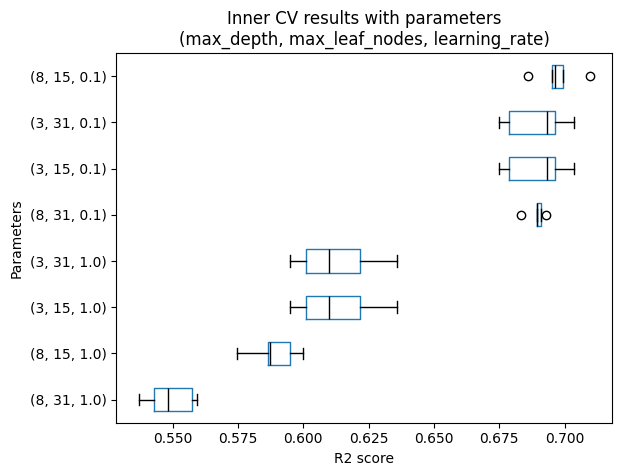

In [ ]:
import matplotlib.pyplot as plt

# Sort the inner_cv_results by the mean of the columns
sorted_inner_cv_results = inner_cv_results.mean().sort_values().index
inner_cv_results = inner_cv_results[sorted_inner_cv_results]

color = {"whiskers": "black", "medians": "black", "caps": "black"}
inner_cv_results.plot.box(vert=False, color=color)
plt.xlabel("R2 score")
plt.ylabel("Parameters")
_ = plt.title(
    "Inner CV results with parameters\n" "(max_depth, max_leaf_nodes, learning_rate)"
)

We see that the first 4 ranked set of parameters are very close. We could select any of these 4 combinations. It coincides with the results we observe when inspecting the best parameters of the outer CV.